In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
import warnings
from transformers import logging as hf_logging
from tqdm import tqdm 

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [135]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [136]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [137]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [138]:
df["label"].value_counts()

Outro          8385
Entrega        4819
Produto        2961
Atendimento    1944
Name: label, dtype: int64

In [139]:
df["label"].value_counts(normalize=True)

Outro          0.463029
Entrega        0.266111
Produto        0.163510
Atendimento    0.107350
Name: label, dtype: float64

In [140]:
dfO = df[df["label"] == "Outro"].sample(frac = 0.26)
dfE = df[df["label"] == "Entrega"].sample(frac = 0.44)
dfP = df[df["label"] == "Produto"].sample(frac = 0.70)

df = pd.concat([dfO, dfE, dfP, df[df["label"] == "Atendimento"]])
df["label"].value_counts()

Outro          2180
Entrega        2120
Produto        2073
Atendimento    1944
Name: label, dtype: int64

In [141]:
df["label"].value_counts(normalize=True)

Outro          0.262114
Entrega        0.254900
Produto        0.249249
Atendimento    0.233738
Name: label, dtype: float64

In [143]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


df["tweets"] = df["tweets"].apply(cleanTxt)
df["tweets"] = df["tweets"].apply(removeEmojis)
df["tweets"] = df["tweets"].apply(removeStopWords)
# tweets = list(tweets_tratados)

In [144]:
#Verificando novamente se houve tweets nulos após tratamento
df["tweets"].isnull().sum()

0

In [146]:
le = LabelEncoder()
df['label_num'] = le.fit_transform(df["label"])

In [147]:
label_dict = (df[['label','label_num']].drop_duplicates()
              .sort_values(by='label_num')
              .reset_index(drop=True)['label']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Atendimento
1 Entrega
2 Outro
3 Produto


In [151]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [153]:
# Splitting the data

# I will take 30% of the training data as validation data

num_train_samples = int(train_df.shape[0] * 0.7)

X_train = train_df['tweets'][:num_train_samples]
y_train = train_df['label_num'][:num_train_samples]
X_val = train_df['tweets'][num_train_samples:]
y_val = train_df['label_num'][num_train_samples:]


### Checando
assert(len(X_train) + len(X_val) == train_df.shape[0])

print(f"{len(X_train)} training examples\n{len(X_val)} validation examples")

4657 training examples
1996 validation examples


In [154]:
X_test = test_df['tweets']
y_test = test_df['label_num']
print(f"{len(X_test)} testing examples")

1664 testing examples


In [156]:
MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

In [157]:
# Finding the max token sequence in the training set

max_val = 0
for sent in (X_train.tolist() + X_train.tolist() + X_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 124


In [158]:
# I will set the max length and input for the deep learning model to 126
# (Max token length + 2 for special characters [CLS] and [SEP])

MAX_LENGTH = max_val + 2

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [159]:
X_train = tokenize(X_train, tokenizer)
X_test = tokenize(X_test, tokenizer)
X_val = tokenize(X_val, tokenizer)

100%|██████████| 1996/1996 [00:01<00:00, 1240.76it/s]


In [ ]:
# Looking at entry

index_num = 5

print(train_df.loc[index_num]['Sentiment'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

In [25]:
# Creating the model

config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(4, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 106)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 106)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']    

In [26]:
# Creating a output directory to store the models weights

output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [28]:
# Callbacks

model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
# Compile and Train


In [338]:
# preparar tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [339]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7771 unique tokens.


In [340]:
# integer codificar os documentos
sequences = tokenizer.texts_to_sequences(tweets)

In [341]:
# preencher documentos com um comprimento máximo de 28 palavras
maxlen = 47
X = pad_sequences(sequences, maxlen=maxlen)

In [342]:
X.shape

(8317, 47)

In [343]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.3, random_state=42)

In [344]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5821, 47), (2496, 47), (5821, 4), (2496, 4))

In [345]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [346]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 47, 32)            248704    
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 47, 32)            2080      
                                                                 
 dropout_28 (Dropout)        (None, 47, 32)            0         
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 47, 32)            2080      
                                                                 
 dropout_29 (Dropout)        (None, 47, 32)            0         
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 4)               

In [347]:
model.save('srnn.h5')

In [348]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Avaliação final do modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
128/128 [==============================] - 9s 41ms/step - loss: 1.3042 - accuracy: 0.3829 - val_loss: 1.2177 - val_accuracy: 0.4299
Epoch 2/10
128/128 [==============================] - 5s 42ms/step - loss: 1.0376 - accuracy: 0.5550 - val_loss: 1.1202 - val_accuracy: 0.5037
Epoch 3/10
128/128 [==============================] - 4s 35ms/step - loss: 0.6751 - accuracy: 0.7565 - val_loss: 1.0856 - val_accuracy: 0.5741
Epoch 4/10
128/128 [==============================] - 5s 36ms/step - loss: 0.3797 - accuracy: 0.8795 - val_loss: 1.3205 - val_accuracy: 0.5398
Epoch 5/10
128/128 [==============================] - 5s 36ms/step - loss: 0.2112 - accuracy: 0.9381 - val_loss: 1.3907 - val_accuracy: 0.5810
Epoch 6/10
128/128 [==============================] - 5s 36ms/step - loss: 0.1940 - accuracy: 0.9406 - val_loss: 1.6710 - val_accuracy: 0.5089
Epoch 7/10
128/128 [==============================] - 5s 36ms/step - loss: 0.1438 - accuracy: 0.9588 - val_loss: 1.6192 - val_accuracy: 0.5461

In [349]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [350]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 47, 32)            248704    
                                                                 
 lstm_21 (LSTM)              (None, 47, 32)            8320      
                                                                 
 dropout_30 (Dropout)        (None, 47, 32)            0         
                                                                 
 lstm_22 (LSTM)              (None, 47, 32)            8320      
                                                                 
 dropout_31 (Dropout)        (None, 47, 32)            0         
                                                                 
 lstm_23 (LSTM)              (None, 32)                8320      
                                                                 
 dense_15 (Dense)            (None, 4)               

In [351]:
model.save('lstm.h5')

In [352]:
start = time.time()
# Ajustar o modelo ao conjunto de treino
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# avaliação final do modelo
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
128/128 [==============================] - 18s 81ms/step - loss: 1.2694 - accuracy: 0.3945 - val_loss: 1.0979 - val_accuracy: 0.5655
Epoch 2/10
128/128 [==============================] - 9s 71ms/step - loss: 0.8563 - accuracy: 0.6711 - val_loss: 0.7445 - val_accuracy: 0.7338
Epoch 3/10
128/128 [==============================] - 9s 68ms/step - loss: 0.5110 - accuracy: 0.8267 - val_loss: 0.7114 - val_accuracy: 0.7481
Epoch 4/10
128/128 [==============================] - 9s 69ms/step - loss: 0.3450 - accuracy: 0.8918 - val_loss: 0.7394 - val_accuracy: 0.7430
Epoch 5/10
128/128 [==============================] - 10s 78ms/step - loss: 0.2558 - accuracy: 0.9227 - val_loss: 0.8433 - val_accuracy: 0.7344
Epoch 6/10
128/128 [==============================] - 10s 81ms/step - loss: 0.2007 - accuracy: 0.9418 - val_loss: 0.8939 - val_accuracy: 0.7350
Epoch 7/10
128/128 [==============================] - 11s 89ms/step - loss: 0.1550 - accuracy: 0.9521 - val_loss: 0.9729 - val_accuracy: 0.

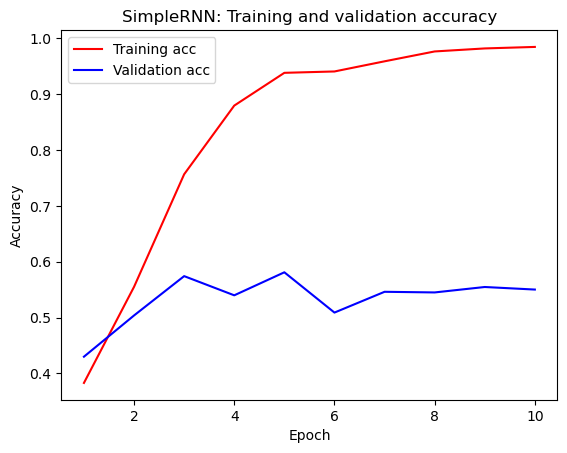

In [353]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

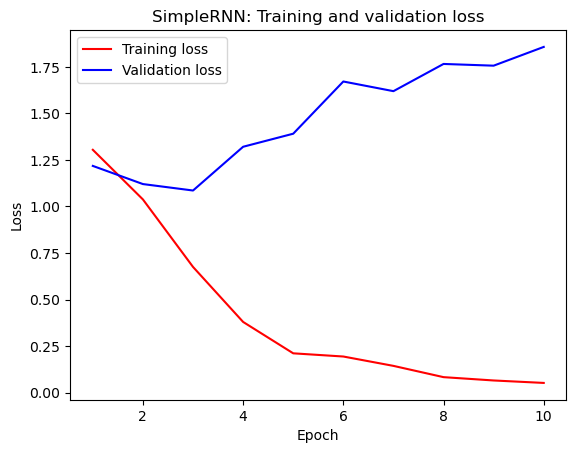

In [354]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

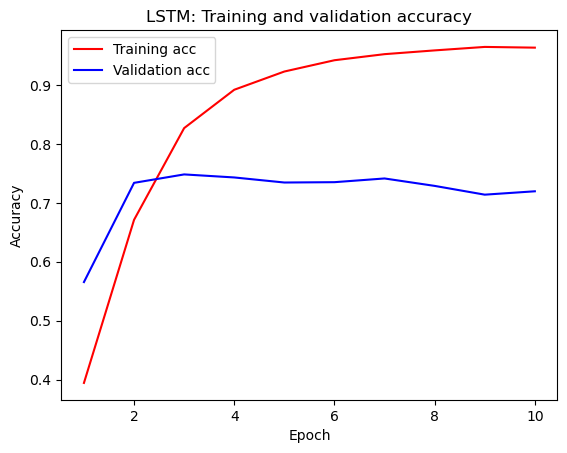

In [355]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

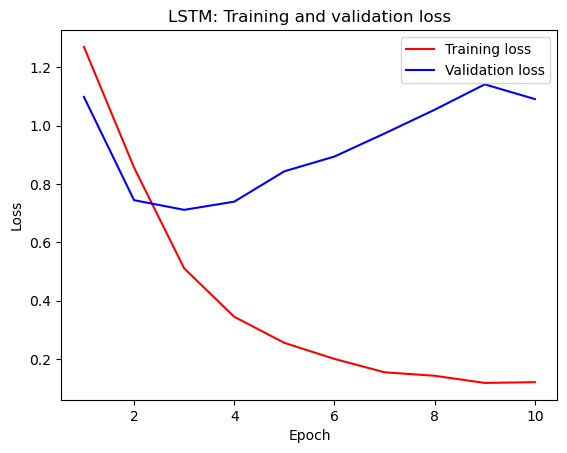

In [356]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [357]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [358]:
lstm.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 47, 32)            248704    
                                                                 
 lstm_21 (LSTM)              (None, 47, 32)            8320      
                                                                 
 dropout_30 (Dropout)        (None, 47, 32)            0         
                                                                 
 lstm_22 (LSTM)              (None, 47, 32)            8320      
                                                                 
 dropout_31 (Dropout)        (None, 47, 32)            0         
                                                                 
 lstm_23 (LSTM)              (None, 32)                8320      
                                                                 
 dense_15 (Dense)            (None, 4)               

In [359]:
predictions = lstm.predict(X_test)

78/78 [==============================] - 3s 21ms/step
